In [1]:
import pickle
from pathlib import Path
from skimage import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import numpy as np
import tensorflow as tf
import random

# Set the seed for Python's random module
random.seed(52)

# Set the seed for NumPy (used for matrix operations and other mathematical computations)
np.random.seed(52)

# Set the seed for TensorFlow (used for neural network training)
tf.random.set_seed(52)

In [2]:
column_names = ['id', 'classifier']
labels = pd.read_csv(r'C:\Users\wilke\Documents\ISL\IMPACT\Mars Classification\msl-labeled-data-set-v2.1\labels.txt', delimiter=' ', names=column_names, header=0, index_col=0)
print(labels['classifier'].value_counts())
y = labels.classifier.values

classifier
3     831
4     793
2     273
7     171
14    135
11    114
8      96
13     74
10     68
6      59
16     56
15     46
1      45
17     32
12     28
9      18
18     13
0      10
5       8
Name: count, dtype: int64


Example image has shape:  (227, 227, 3)
RGB values for the top left pixel are: [163  26   8]


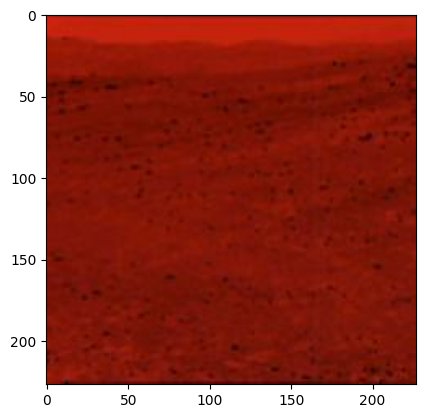

In [3]:
example_image = io.imread(r'C:\Users\wilke\Documents\ISL\IMPACT\Mars Classification\msl-labeled-data-set-v2.1\images\{}'.format(labels.index[0]))
plt.imshow(example_image)
print('Example image has shape: ', example_image.shape)
print('RGB values for the top left pixel are:', example_image[0, 0, :])

In [4]:
image_list = []

for i in labels.index:
    img = io.imread(r'C:\Users\wilke\Documents\ISL\IMPACT\Mars Classification\msl-labeled-data-set-v2.1\images\{}'.format(i)).astype(np.float64)
    image_list.append(img)
X = np.array(image_list)
print(X.shape)

(2870, 227, 227, 3)


In [5]:
x_interim, x_eval, y_interim, y_eval = train_test_split(X, y, test_size=0.2, random_state=52)
x_train, x_test, y_train, y_test = train_test_split(x_interim, y_interim, test_size=0.4, random_state=52)

from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=19)
y_test = to_categorical(y_test, num_classes=19)
y_eval = to_categorical(y_eval, num_classes=19)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'x_train samples')
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')

x_train shape: (1377, 227, 227, 3)
1377 x_train samples
919 test samples
574 eval samples


In [6]:
x_train = x_train / 255.0
x_eval = x_eval / 255.0
x_test = x_test / 255.0

In [7]:
num_classes = 19
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(227, 227, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

In [8]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(227, 227, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='preds'))  

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 225, 225, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 55, 55, 64)        0         
                                                                 
 flatten (Flatten)           (None, 193600)           

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(0.0001), 
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
history = model.fit(x_train, y_train, 
          epochs=20,  # Increase number of epochs to 20
          verbose=1, 
          validation_data=(x_test, y_test),
          callbacks=[early_stopping])  # Add early stopping callback

# Evaluate the model
eval_loss, eval_acc = model.evaluate(x_eval, y_eval)
print(f"Eval loss: {eval_loss}, Eval accuracy: {eval_acc}")

Epoch 1/20
44/44 [==============================] - 37s 811ms/step - loss: 2.4974 - accuracy: 0.2469 - val_loss: 2.1919 - val_accuracy: 0.3090
Epoch 2/20
44/44 [==============================] - 33s 757ms/step - loss: 2.2852 - accuracy: 0.2934 - val_loss: 2.1360 - val_accuracy: 0.2949
Epoch 3/20
44/44 [==============================] - 33s 762ms/step - loss: 2.2162 - accuracy: 0.3079 - val_loss: 2.0555 - val_accuracy: 0.4200
Epoch 4/20
44/44 [==============================] - 33s 763ms/step - loss: 2.1004 - accuracy: 0.3486 - val_loss: 1.9846 - val_accuracy: 0.4744
Epoch 5/20
44/44 [==============================] - 38s 867ms/step - loss: 2.0705 - accuracy: 0.3638 - val_loss: 1.8787 - val_accuracy: 0.4298
Epoch 6/20
44/44 [==============================] - 38s 860ms/step - loss: 1.9328 - accuracy: 0.4139 - val_loss: 1.8468 - val_accuracy: 0.4962
Epoch 7/20
44/44 [==============================] - 38s 868ms/step - loss: 1.8933 - accuracy: 0.4365 - val_loss: 1.7867 - val_accuracy: 0.5441

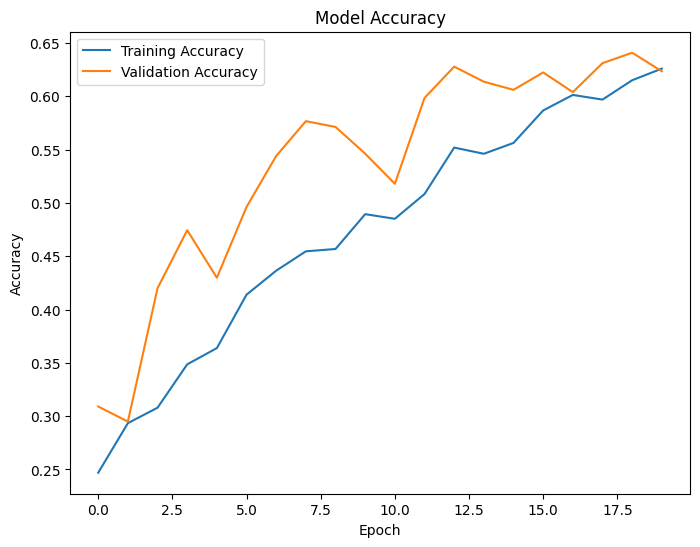

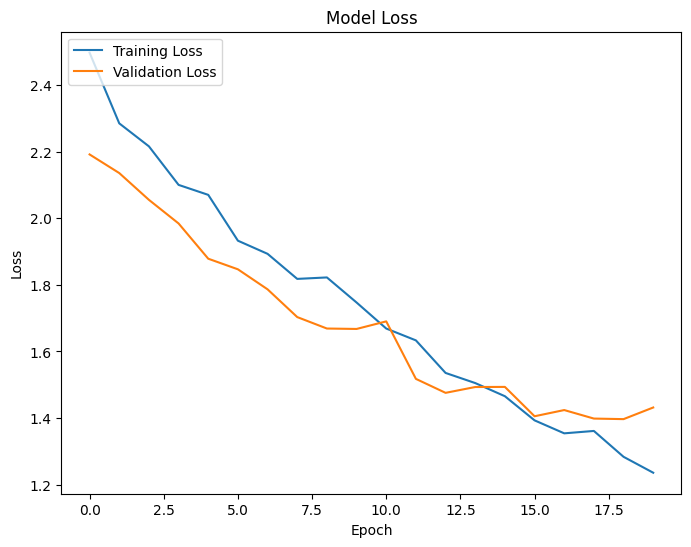

In [13]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

plt.figure(figsize=[8,6])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [15]:
import pickle

with open('model_history_run2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [16]:
model.save('mars_classifier_model_run2.keras')
#load from tensorflow.keras.models import load_model
#model = load_model('mars_classifier_model.keras')